### Introduction
In this notebook we will implement value iteration and use it to solve the gambler's problem. This is based on the book by Sutton-Barto, specifically this version: https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf

Gambler's problem: 
- 0-100 dollars
- bet as much money as he has available, an unfair coin is flipped, if come up he wins the amount he bets
- Goal in life - reach 100

### Choosing a $\gamma$
Recall that $\gamma \in [0, 1]$ is the discount factor used to compute the expected discounted returns
$$G_t = \sum_{k = 0}^\infty \gamma^k R_{t + k + 1}.$$
This hyperparameter $\gamma$ controls how farsighted the agent is, and it also ensures that $G_t$ is finite in the case of infinitely many bounded nonzero terms. (See Sections 3.3, 3.4 in Sutton-Barto.) Choose $\gamma$ for the present case of a finite MDP.

Greedy Algorithms - Algorithm are ssumed to be greedy. One that always takes the current-best action. Follow the algorithm blindly to find the local minimum. Algorithm should always be greedy

Exs 
- Gradient descent is greedy and not optimal. 
- Policy iteration alg/value iteration algorithm are greedy and optimal 
- Top k-eigenvector solution is optimal. 

Ex of a problem where greedy is very not optimal: 

    knapsack avail gold bars w/ weights w1,....,wn and have a knapsack that can hold c (weight). Which gold bars do you take? 
    
    Example: (w1,w2,w3) = (4,3,2), C=5

In [1]:
# TODO: define `GAMMA`
GAMMA = 1

### General objects
Here is a general class template that represents a finite Markov decision process (MDP).

In [2]:
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import numpy as np

class MDP:

    @property
    def states(self):
        '''
        Returns:
            (set) The states of this MDP.
        '''
        pass

    def actions(self, state):
        '''
        Returns:
            (set) The actions allowed from `state`.
        '''
        pass

    def psr(self, state, action):
        '''
        Returns:
            (set) The set of tuples (p, s, r) where `s` is a state reachable
                from `state` by performing `action`, `p` is the probability
                of reaching `s`, and `r` is the reward gained by reaching `s`.
                In particular, the sum of the `p` equals 1.
        '''
        pass

### Implementing the gambler's problem
To make our implementation compatible with value iteration, we will include the state `self.goal`. Recall that the reward of reaching the goal is $1$ and that the reward of reaching any other state is $0.$ Moreover, recall that the MDP ends once either `0` or `self.goal` is reached. How should the state `self.goal` behave, e.g. what should the available actions and rewards from this state be? With this in mind, fix the below naive implementation of the gambler's problem. You can use the rest of the notebook (in particular the last cell) to test your implementation.

In [3]:
class GamblersProblem(MDP):
    '''
    The gambler's problem, as described in Example 4.3 of Sutton-Barto.
    '''
    
    def __init__(self, p_h, goal):
        assert 0 <= p_h <= 1
        self.p_h = p_h
        self.goal = goal

    @property
    def states(self): # TODO: fix this
        return set(range(self.goal+1))

    def actions(self, state): # TODO: fix this
        if state in {0, self.goal}:
            return {0}
        else:
            return set(range(1, 1+min(state, self.goal - state)))

    def psr(self, state, action): # TODO: fix this
        return {
            (
                self.p_h, # heads, i.e. the gambler wins money
                state + action,
                1 if state + action == self.goal and action != 0 else 0
            ), (
                1 - self.p_h, # tails, i.e. the gambler loses money
                state - action,
                0
            ) 
        }

    def plot_policy(self, policy):
        for s, actions in policy.items():
            xy = [(s, action) for action in actions]
            plt.scatter(
                *zip(*xy),
                # purple if there are multiple actions
                color='purple' if len(actions) > 1 else 'blue', 
                marker='.'
            )
            plt.title("Policy")
            plt.xlabel("Capital")
            plt.ylabel("Stake")

    def plot_value(self, value):
        xy = [(s, v) for s, v in value.items()]
        plt.plot(*zip(*xy))
        # plt.title("Value estimates")
        # plt.xlabel("Capital")
        # plt.ylabel("Value estimates")

### Value functions

Here is a general class that represents a value function on a finite MDP. Implement the `truncated_evaluations` and `greedy_policy` methods, replacing the currently obfuscated code, recalling that the truncated evaluation (see Section 4.4 in Sutton-Barto) for a value function $v,$ a state $s,$ and an action $a$ is
$$\mathbb{E}[R_{t + 1} + \gamma v(S_{t + 1}) \mid S_t = s, A_t = a] = \sum_{(s', r)} p(s', r \mid s, a)[r + \gamma v(s')].$$

In [4]:
class Value(dict):

    def truncated_evaluations(self, mdp): # TODO: implement this - implement it in the same way - make it not truncated
        '''
        Returns:
            (dict) The truncated policy evaluations for every state and
                every action. The keys are the states, and the values are
                dicts keyed by actions with value the truncated policy
                evaluation of performing the action at the state.
        '''
        # the following code works (so that the rest of the notebook works)
        # but is obfuscated - don't include this
        # truncated_evals = {}
        # for state in mdp.states:
        #     evals_for_state = {}
        #     for action in mdp.actions(state):
        #         truncated_eval = 0
        #         for prob, next_state, reward in mdp.psr(state, action):
        #             truncated_eval += prob * (reward + GAMMA * self[next_state])
        #         evals_for_state[action] = truncated_eval
        #     truncated_evals[state] = evals_for_state
        # return truncated_evals

        truncated_evals = {}
        
        return {
            state: {
                action: sum(prob * (reward + GAMMA * self[next_state]) for prob, next_state, reward in mdp.psr(state, action))
                for action in mdp.actions(state)
            }
            for state in mdp.states
        }

        return truncated_evals

    def greedy_policy(self, mdp, tiebreak='equal_split'):
        '''
        The greedy policy (with respect to the truncated policy evaluations).

        Args:
            tiebreaker: Decides what to do in case there are multiply actions
                with the same truncated policy evaluation. The options are
                'equal_split' (of the probabilities), 'max' (of the actions),
                'min' (of the actions), 'random' (action).
        '''
        greedy_actions = {
            s: {a for a, v in evals.items() if v == max(evals.values())}
            for s, evals in self.truncated_evaluations(mdp).items()
        }
        tiebreaker = lambda actions: {
            'equal_split': {a: 1 / len(actions) for a in actions},
            'max': {max(actions): 1.0},
            'min': {min(actions): 1.0},
            'random': {random.choice(list(actions)): 1.0},
        }[tiebreak]
        return {
            s: tiebreaker(actions)
            for s, actions in greedy_actions.items()
        }

### Value iteration algorithm
The pseudocode for value iteration in Sutton-Barto (see Figure 4.5 in Sutton-Barto on page 101) has a slight error. Namely, it is using asynchronous dynamic programming (see the following Section 4.5 in Sutton-Barto) because it updates $V(s)$ in place, i.e. it is using the updated value of $V(s)$ for the subsequent computations of $V(s')$ for other $s'.$ The pseudocode is also non-Pythonic. Below is an implementation following their pseudocode, which we will use during section. Reimplement this so that it is the intended algorithm and in a Pythonic way.

In [5]:
def value_iteration_algorithm(mdp, theta=1e-15, max_iter=1000, tiebreak='equal_split'): #1000 instead of 100
    '''
    The value iteration algorithm (but not really, because see above) following
    the pseudocode in Sutton-Barto.
    '''
    # TODO: Reimplement this.
    
    V = Value({state: 0 for state in mdp.states})
    pbar = tqdm(range(max_iter))
    for _ in pbar:
        Delta = 0
        # for s in mdp.states:
        #     v = V[s]
        #     V[s] = max(V.truncated_evaluations(mdp)[s].values())
        #     Delta = max(Delta, abs(v - V[s]))
        # if Delta < theta:
        #     break
        a = V.truncated_evaluations(mdp)
        new_V = Value({state: max(a[state].values()) for state in mdp.states})
        # new_V = Value(max(V.truncated_evaluations(mdp).values()))
        Delta = max(Delta, max(abs(new_V[state] - V[state]) for state in mdp.states))
        V = new_V
        if Delta < theta:
            break
        
        mdp.plot_value(V)
        pbar.set_description(f'{Delta=:<6.3}  {V[50]=:<6.3}  {V[100]=:<6.3}')
    plt.show()
    
    return V.greedy_policy(mdp, tiebreak=tiebreak)

# In this modified version, the new_V dictionary is updated using the values from the current iteration of V. 
#  Then, after computing the maximum change in values, we update the V dictionary synchronously with the new values. 
# This ensures that all states are updated based on the same iteration's values, making it synchronous dynamic programming.

### Playing around with the gambler's problem
Use the cell below to test various values of $p_h.$

  0%|          | 0/1000 [00:00<?, ?it/s]

Delta=2.33e-15  V[50]=0.25    V[100]=0.0   :   4%|▍         | 41/1000 [00:00<00:04, 205.90it/s]


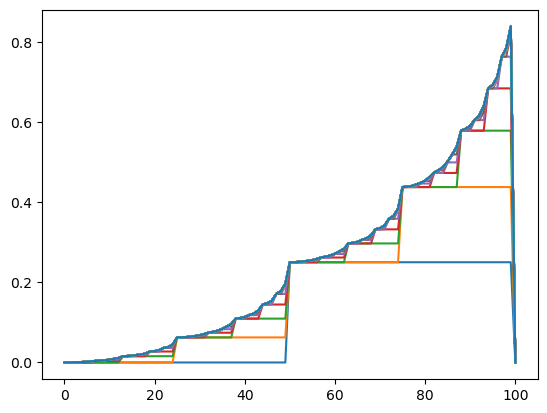

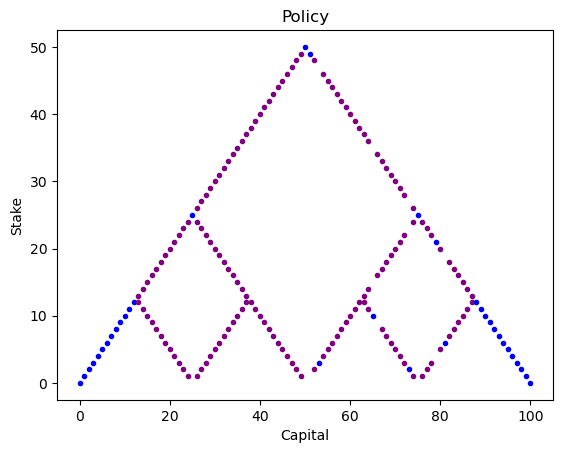

In [6]:
mdp = GamblersProblem(0.25, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split'))
plt.show()

Delta=0.303   V[50]=0.55    V[100]=0.0   :   0%|          | 0/1000 [00:00<?, ?it/s]

Delta=4.73e-05  V[50]=0.999   V[100]=0.0   : 100%|██████████| 1000/1000 [00:03<00:00, 313.18it/s]


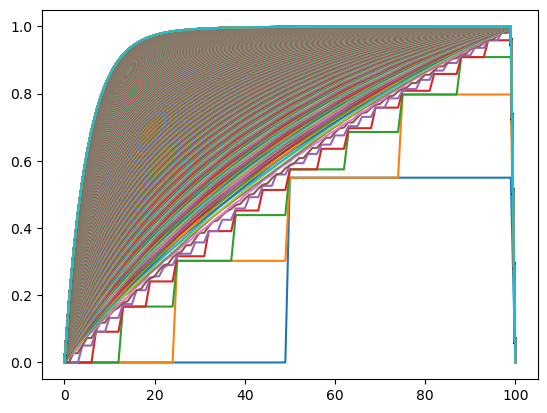

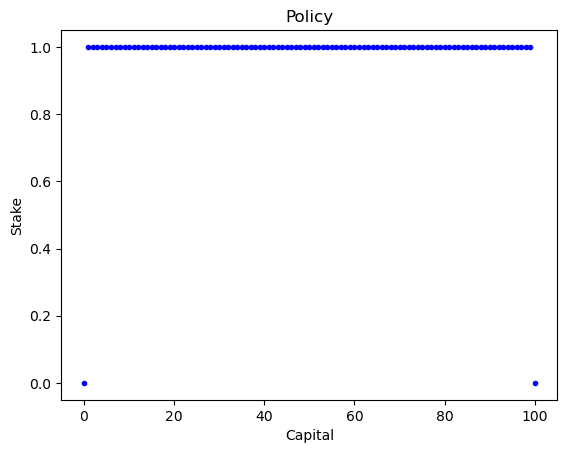

In [7]:
mdp = GamblersProblem(0.55, 100)
mdp.plot_policy(value_iteration_algorithm(mdp, theta=1e-15, tiebreak='equal_split', max_iter=1000))
plt.show()

In [ ]:
# gotta bet small - should never bet 3 dollar - should always bet 1 dollar
# always prefer betting 1 dollar rather than 3 dollars